### importing libraries

In [1]:
from tensorflow.keras import layers, models, datasets, Model
from PIL import Image

2025-07-31 01:42:04.418339: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-31 01:42:04.621720: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-31 01:42:04.703345: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753936924.854290   30554 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753936924.890594   30554 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753936925.164006   30554 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

### loading data

In [ ]:
# EXEMPLO AQUI: É NESSE FORMATO QUE PRECISAMOS


(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# Setting input shape, normalizing color channel, setting datatype to float32 for numerical stability
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255

classes = [str(i) for i in range(10)]

### Data preprocessing 

#### Image size reduction
2.5 x reduction --> 6.25 pixel number reduction

In [6]:
import os
import cv2
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

# --- Configuration ---
SOURCE_DIR = './data/train/'      # Folder with class subfolders (e.g., A, B, C...)
OUTPUT_DIR = './data/resized/'    # Where to save the resized images
NEW_SIZE = (40, 30)               # New size for the images (width, height)

# --- 1. Function to resize and save a single image ---
def resize_and_save(relative_path):
    """
    Reads an image from its relative path, resizes it, and saves it to the
    output directory while maintaining the subfolder structure.
    """
    try:
        # Construct the full input and output paths
        full_input_path = os.path.join(SOURCE_DIR, relative_path)
        full_output_path = os.path.join(OUTPUT_DIR, relative_path)

        # Create the destination subdirectory if it doesn't exist
        os.makedirs(os.path.dirname(full_output_path), exist_ok=True)

        # Read the image
        image = cv2.imread(full_input_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            # print(f"Warning: Could not read {full_input_path}, skipping.")
            return 0 # Return 0 for failure

        # Resize the image using INTER_AREA for best downscaling results
        resized_image = cv2.resize(image, NEW_SIZE, interpolation=cv2.INTER_AREA)

        # Save the resized image
        cv2.imwrite(full_output_path, resized_image)
        return 1 # Return 1 for success
    except Exception as e:
        print(f"Error processing {relative_path}: {e}")
        return 0

# --- 2. Main execution block to run the process in parallel ---
if __name__ == "__main__":
    # Find all image files in the source directory and its subdirectories
    all_image_paths = []
    for root, _, files in os.walk(SOURCE_DIR):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                # Get the path relative to the source directory (e.g., "A/image1.png")
                relative_path = os.path.relpath(os.path.join(root, file), SOURCE_DIR)
                all_image_paths.append(relative_path)
    
    if not all_image_paths:
        print(f"No images found in {SOURCE_DIR}. Please check the path.")
    else:
        print(f"Found {len(all_image_paths)} images to resize. Starting process...")

        # Use ProcessPoolExecutor to run resizing on all available CPU cores
        with ProcessPoolExecutor() as executor:
            # Use tqdm to create a progress bar
            results = list(tqdm(executor.map(resize_and_save, all_image_paths), total=len(all_image_paths)))

        total_processed = sum(results)
        print(f"\n✅ Done! Successfully resized and saved {total_processed} images to {OUTPUT_DIR}")

Found 24850 images to resize. Starting process...


100%|██████████| 24850/24850 [00:10<00:00, 2311.73it/s]



✅ Done! Successfully resized and saved 24850 images to ./data/resized/


#### Thresholding

##### OTSU

In [7]:
import os
import cv2
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

# --- Configuration ---
# Use the resized images as the source for maximum efficiency
SOURCE_DIR = './data/resized/'
OUTPUT_DIR = './data/thresholded/'

# --- 1. Function to threshold and save a single image ---
def threshold_and_save(relative_path):
    """
    Reads an image, applies Otsu's thresholding, and saves the result.
    """
    try:
        # Construct full input and output paths
        full_input_path = os.path.join(SOURCE_DIR, relative_path)
        full_output_path = os.path.join(OUTPUT_DIR, relative_path)

        # Create the destination subdirectory if it doesn't exist
        os.makedirs(os.path.dirname(full_output_path), exist_ok=True)

        # Read the image in grayscale
        image = cv2.imread(full_input_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            return 0  # Return 0 for failure

        # Apply Otsu's thresholding
        # The [1] selects the image array from the tuple returned by cv2.threshold
        thresholded_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

        # Save the thresholded image
        cv2.imwrite(full_output_path, thresholded_image)
        return 1  # Return 1 for success
    except Exception as e:
        print(f"Error processing {relative_path}: {e}")
        return 0

# --- 2. Main execution block to run the process in parallel ---
if __name__ == "__main__":
    # Find all image files in the source directory
    all_image_paths = []
    for root, _, files in os.walk(SOURCE_DIR):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                relative_path = os.path.relpath(os.path.join(root, file), SOURCE_DIR)
                all_image_paths.append(relative_path)

    if not all_image_paths:
        print(f"No images found in {SOURCE_DIR}. Please check the path.")
    else:
        print(f"Found {len(all_image_paths)} images to threshold. Starting process...")

        # Use ProcessPoolExecutor to run on all available CPU cores
        with ProcessPoolExecutor() as executor:
            # Use tqdm to create a progress bar
            results = list(tqdm(executor.map(threshold_and_save, all_image_paths), total=len(all_image_paths)))

        total_processed = sum(results)
        print(f"\n✅ Done! Successfully processed and saved {total_processed} images to {OUTPUT_DIR}")

Found 24850 images to threshold. Starting process...


100%|██████████| 24850/24850 [00:09<00:00, 2746.48it/s]



✅ Done! Successfully processed and saved 24850 images to ./data/thresholded/


##### Adaptive Thresholding

In [8]:
import os
import cv2
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

# --- Configuration ---
SOURCE_DIR = './data/resized/'
OUTPUT_DIR = './data/adaptive_thresholded/'
BLOCK_SIZE = 15  # Must be an odd number (e.g., 11, 15, 21)
C_CONSTANT = 4   # Constant to subtract from the mean (fine-tune this)

# --- 1. Function to apply adaptive thresholding and save ---
def adaptive_threshold_and_save(relative_path):
    """
    Reads an image, applies adaptive thresholding, and saves the result.
    """
    try:
        full_input_path = os.path.join(SOURCE_DIR, relative_path)
        full_output_path = os.path.join(OUTPUT_DIR, relative_path)

        os.makedirs(os.path.dirname(full_output_path), exist_ok=True)

        image = cv2.imread(full_input_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            return 0

        # Apply Adaptive Thresholding
        thresholded_image = cv2.adaptiveThreshold(
            image,
            255,                                  # Max value to assign
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,       # Method to calculate threshold
            cv2.THRESH_BINARY_INV,                # Invert the image (character is white)
            BLOCK_SIZE,                           # Neighborhood size
            C_CONSTANT                            # Constant to subtract
        )

        cv2.imwrite(full_output_path, thresholded_image)
        return 1
    except Exception as e:
        print(f"Error processing {relative_path}: {e}")
        return 0

# --- 2. Main execution block ---
if __name__ == "__main__":
    all_image_paths = []
    for root, _, files in os.walk(SOURCE_DIR):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                relative_path = os.path.relpath(os.path.join(root, file), SOURCE_DIR)
                all_image_paths.append(relative_path)

    if not all_image_paths:
        print(f"No images found in {SOURCE_DIR}. Please check the path.")
    else:
        print(f"Found {len(all_image_paths)} images to process. Starting...")

        with ProcessPoolExecutor() as executor:
            results = list(tqdm(executor.map(adaptive_threshold_and_save, all_image_paths), total=len(all_image_paths)))

        total_processed = sum(results)
        print(f"\n✅ Done! Processed {total_processed} images saved to {OUTPUT_DIR}")

Found 24850 images to process. Starting...


100%|██████████| 24850/24850 [00:09<00:00, 2648.44it/s]



✅ Done! Processed 24850 images saved to ./data/adaptive_thresholded/


#### Data cleaning
Removing bad examples from the training dataset

In [ ]:
import os
import cv2
import numpy as np
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

# --- Configuration: TUNE THESE VALUES ---
SOURCE_DIR = './data/thresholded/'
OUTPUT_DIR = './data/cleaned/'

# -- Contour Filters --
MIN_CONTOURS = 1      # Minimum number of contours to be considered valid
MAX_CONTOURS = 3     # Maximum number of contours (to filter out noisy images)

# This filters out images that are mostly blank or mostly solid white
MIN_AREA_RATIO = 0.20 
MAX_AREA_RATIO = 0.80  

def analyze_and_filter_image(relative_path):
    try:
        full_input_path = os.path.join(SOURCE_DIR, relative_path)
        image = cv2.imread(full_input_path, cv2.IMREAD_GRAYSCALE)
        if image is None: return 0

        # Find all contours in the binary image
        contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # --- Apply Filtering Logic ---
        # 1. Filter by number of contours
        if not (MIN_CONTOURS <= len(contours) <= MAX_CONTOURS):
            return 0 # Discard

        # 2. Filter by the area of the largest contour
        image_area = image.shape[0] * image.shape[1]
        largest_contour = max(contours, key=cv2.contourArea)
        contour_area = cv2.contourArea(largest_contour)
        area_ratio = contour_area / image_area
        
        if not (MIN_AREA_RATIO <= area_ratio <= MAX_AREA_RATIO):
            return 0 # Discard
        
        # --- If all checks pass, copy the file ---
        full_output_path = os.path.join(OUTPUT_DIR, relative_path)
        os.makedirs(os.path.dirname(full_output_path), exist_ok=True)
        cv2.imwrite(full_output_path, image) # Using cv2.imwrite to copy
        
        return 1 # Keep
    except Exception:
        return 0

# --- 2. Main execution block ---
if __name__ == "__main__":
    all_image_paths = []
    for root, _, files in os.walk(SOURCE_DIR):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                relative_path = os.path.relpath(os.path.join(root, file), SOURCE_DIR)
                all_image_paths.append(relative_path)

    if not all_image_paths:
        print(f"No images found in {SOURCE_DIR}.")
    else:
        print(f"Found {len(all_image_paths)} images to clean. Starting process...")

        with ProcessPoolExecutor() as executor:
            results = list(tqdm(executor.map(analyze_and_filter_image, all_image_paths), total=len(all_image_paths)))

        total_kept = sum(results)
        total_discarded = len(all_image_paths) - total_kept
        print(f"\n✅ Done! Kept {total_kept} images and discarded {total_discarded}.")
        print(f"Cleaned images are saved in {OUTPUT_DIR}")

Found 24850 images to clean. Starting process...


100%|██████████| 24850/24850 [00:08<00:00, 2804.88it/s]



✅ Done! Kept 22864 images and discarded 1986.
Cleaned images are saved in ./data/cleaned/


#### Checking for dataset balance after cleaning

Number of classes: 35


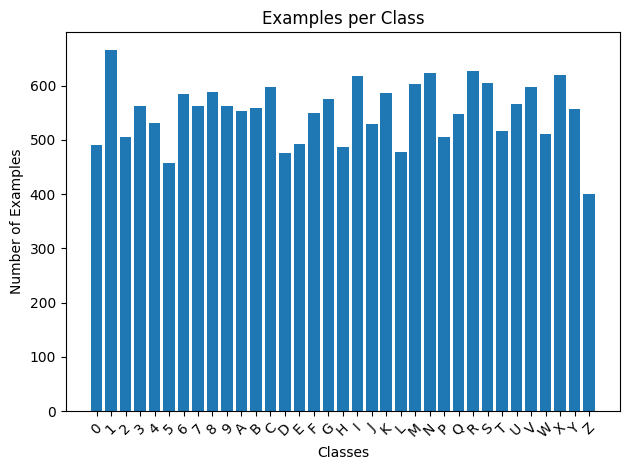


Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Examples per class: [490, 665, 505, 563, 532, 457, 585, 562, 589, 563, 553, 558, 597, 476, 493, 550, 576, 486, 618, 530, 587, 477, 603, 623, 506, 547, 627, 605, 516, 566, 597, 510, 619, 556, 401]
Total examples: 19288
Average examples per class: 551.09


In [19]:
#!/usr/bin/env python3
"""
Data Exploration Script
Converted from data-exploration.ipynb
"""

# Importing libraries
import os
from matplotlib import pyplot as plt

# Checking the training dataset

# Checking the number of examples to guarantee balanced training
base_path = "./data/cleaned/" 
classes = [entry.name for entry in os.scandir(base_path)]
print(f"Number of classes: {len(classes)}")

# Count examples per class and create bar chart
examples_count = [len(list(os.scandir(f"{base_path}/{char}"))) for char in classes]
plt.bar(classes, examples_count)
plt.title("Examples per Class")
plt.xlabel("Classes")
plt.ylabel("Number of Examples")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nClasses: {classes}")
print(f"Examples per class: {examples_count}")
print(f"Total examples: {sum(examples_count)}")
print(f"Average examples per class: {sum(examples_count) / len(examples_count):.2f}")

#### Data augmentation

Number of classes: 35


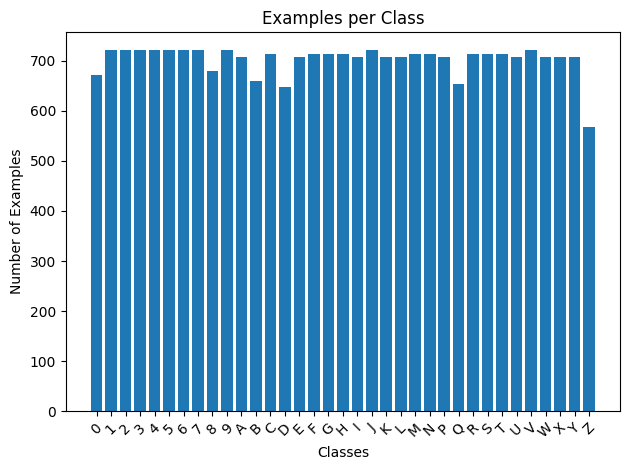


Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Examples per class: [671, 721, 721, 721, 721, 721, 721, 721, 679, 721, 707, 660, 714, 647, 707, 714, 714, 714, 707, 721, 707, 707, 714, 714, 707, 654, 714, 714, 714, 707, 721, 707, 707, 707, 567]
Total examples: 24584
Average examples per class: 702.40


In [ ]:
import os
import cv2
import albumentations as A
from concurrent.futures import ProcessPoolExecutor

# --- Configuration ---
BASE_PATH = "./data/train/"
SOURCE_DIR = BASE_PATH
OUTPUT_DIR = './data/train/augmented_data'
NUM_AUGMENTATIONS_PER_IMAGE = 10 # How many new versions to create for each original

# These are good augmentations for character OCR. They are applied with some probability.
transform = A.Compose([
    A.Affine(
        translate_percent=0.05,
        scale=(0.95, 1.05),
        rotate=(-10, 10),
        p=0.8
    ),
    A.MotionBlur(blur_limit=5, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.7),
])

def augment_and_save(image_filename):
    # Create output directory if it doesn't exist
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)

    filepath = os.path.join(SOURCE_DIR, image_filename)
    try:
        # Read the image using OpenCV
        image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Warning: Could not read {image_filename}, skipping.")
            return 0

        # Generate and save augmented images
        saved_count = 0
        base_filename = os.path.splitext(image_filename)[0]
        
        for i in range(NUM_AUGMENTATIONS_PER_IMAGE):
            augmented = transform(image=image)
            augmented_image = augmented['image']

            new_filename = f"{base_filename}_aug_{i}.png"
            output_path = os.path.join(OUTPUT_DIR, new_filename)
            
            # Create subdirectory if it doesn't exist
            os.makedirs(os.path.dirname(output_path), exist_ok=True)
            
            cv2.imwrite(output_path, augmented_image)
            saved_count += 1
        return saved_count
    except Exception as e:
        print(f"Error processing {image_filename}: {e}")
        return 0


not perfect, but acceptable

In [ ]:

folders = [entry.name for entry in os.scandir(BASE_PATH)]

for folder_name in folders:
  print(folder_name)

  image_files = [f"{folder_name}/{f}" for f in os.listdir(SOURCE_DIR+folder_name) if f.endswith(('.png'))]

  # Use ProcessPoolExecutor to run augmentations on all available CPU cores
  with ProcessPoolExecutor() as executor:
      results = executor.map(augment_and_save, image_files)

  # total_saved = sum(results)
  # print(f"\nGenerated a total of {total_saved} augmented images for class")

### architecture

Input -> Conv2D -> ReLU -> MaxPool2D -> Conv2D -> ReLU -> MaxPool2D -> Flatten -> Dense -> ReLU -> Dense (Output) -> Softmax
Use batch normalization
IF SIGNS OF OVERFITTING: DROPOUT. IF OVER REGULARIZED: L2 REG (WD) 

In [3]:
#@title Model: convolutional layers

model = models.Sequential()


model.add(layers.Conv2D(24, (3, 3), activation = 'relu', input_shape = (28, 28, 1))) # -> (25,25,1)
model.add(layers.MaxPooling2D((2, 2))) # -> (23,23,1)

model.add(layers.Conv2D(48, (3, 3), strides=(2,2), activation = 'relu')) # -> (10,10,1)
model.add(layers.MaxPooling2D((2, 2))) # -> (8,8,1)


c:\Users\Enzo Racciatti\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [4]:
#@title Model: Fully connected layers

model.add(layers.Flatten())
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(32, activation = 'softmax'))

In [5]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 24)     │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 6, 6, 48)       │        10,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 3, 3, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 432)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,448 (158.00 KB)

 Trainable params: 40,448 (158.00 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
#@title Compilação
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

### training


#### early stopping config

In [ ]:

from tensorflow.keras.callbacks import EarlyStopping


# Configure the callback
# 'monitor' is the metric to watch.
# 'patience' is the number of epochs to wait for improvement.
# 'restore_best_weights=True' automatically loads the model weights from the best epoch.

early_stopper = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#### Learning rate scheduler config

In [ ]:

from tensorflow.keras.callbacks import ReduceLROnPlateau
# Configure the callback
lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.2, # Factor by which to reduce the LR: new_lr = lr * factor
                                 patience=2, # Number of epochs with no improvement to wait
                                 min_lr=0.00001) # Lower bound on the learning rate



#### Traning itself

In [ ]:

history = model.fit(train_images,
                    train_labels,
                    epochs = 1,
                    validation_data = (test_images, test_labels))



# Pass the callback to model.fit()
# Make sure to provide validation data!
model.fit(train_ds,
          epochs=100, # Set a high number, early stopping will find the right time.
          validation_data=val_ds,
          callbacks=[early_stopper]) # Pass it in a list

### Evaluation

In [8]:
test_error, test_acc = model.evaluate(test_images, test_labels, verbose=2)

313/313 - 2s - 8ms/step - accuracy: 0.9860 - loss: 0.1554


### Post-training efficiency increase
Quantization, ...

In [13]:
import os
import cv2
import numpy as np

def carregar_dados_como_tuplas(diretorio_base, tamanho=(75, 100)):
    tuplas = []

    # Percorrer todas as subpastas
    for classe in sorted(os.listdir(diretorio_base)):
        caminho_classe = os.path.join(diretorio_base, classe)

        # Apenas se for diretório e não for a classe 'O'
        if os.path.isdir(caminho_classe) and classe != 'O':
            for arquivo in os.listdir(caminho_classe):
                caminho_imagem = os.path.join(caminho_classe, arquivo)

                imagem = cv2.imread(caminho_imagem, cv2.IMREAD_GRAYSCALE)
                if imagem is None:
                    continue

                # Redimensionar
                imagem = cv2.resize(imagem, tamanho)

                # Normalizar e adicionar dimensão para CNN
                imagem = imagem.astype('float32') / 255.0
                imagem = np.expand_dims(imagem, axis=-1)

                tuplas.append((imagem, classe))
    
    return tuplas


# Caminhos (ajustáveis)
caminho_train = 'data/train'
caminho_eval = 'data/eval'

# Carregar os dados
dados_train = carregar_dados_como_tuplas(caminho_train)
dados_eval = carregar_dados_como_tuplas(caminho_eval)

# Dados combinados (se quiser juntar tudo)
todos_os_dados = dados_train + dados_eval

# Exemplo de visualização
print(f'Treino: {len(dados_train)} imagens')
print(f'Avaliação: {len(dados_eval)} imagens')
print(f'Exemplo: shape da imagem = {dados_train[0][0].shape}, rótulo = {dados_train[0][1]}')

Treino: 24850 imagens
Avaliação: 10650 imagens
Exemplo: shape da imagem = (100, 75, 1), rótulo = 0


'0'

#### Readying the training data

In [ ]:
import os
import cv2
import numpy as np

def carregar_dados_como_tuplas(diretorio_base, tamanho=(75, 100)):
    tuplas = []

    # Percorrer todas as subpastas
    for classe in sorted(os.listdir(diretorio_base)):
        caminho_classe = os.path.join(diretorio_base, classe)

        # Apenas se for diretório e não for a classe 'O'
        if os.path.isdir(caminho_classe) and classe != 'O':
            for arquivo in os.listdir(caminho_classe):
                caminho_imagem = os.path.join(caminho_classe, arquivo)

                imagem = cv2.imread(caminho_imagem, cv2.IMREAD_GRAYSCALE)
                if imagem is None:
                    continue

                # Redimensionar
                imagem = cv2.resize(imagem, tamanho)

                # Normalizar e adicionar dimensão para CNN
                imagem = imagem.astype('float32') / 255.0
                imagem = np.expand_dims(imagem, axis=-1)

                tuplas.append((imagem, classe))
    
    return tuplas


# Caminhos (ajustáveis)
caminho_train = 'data/train'
caminho_eval = 'data/eval'

# Carregar os dados
dados_train = carregar_dados_como_tuplas(caminho_train)
dados_eval = carregar_dados_como_tuplas(caminho_eval)

# Dados combinados (se quiser juntar tudo)
todos_os_dados = dados_train + dados_eval

# Exemplo de visualização
print(f'Treino: {len(dados_train)} imagens')
print(f'Avaliação: {len(dados_eval)} imagens')
print(f'Exemplo: shape da imagem = {dados_train[0][0].shape}, rótulo = {dados_train[0][1]}')